<a href="https://colab.research.google.com/github/ShabanNM/ShabanNM/blob/main/Cifar10_CNN_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name**: ***Shaban Mohamed Namatsi***
<br><br>

ID: USER1296211/ R2105D12296211


In [ ]:
%matplotlib inline
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

Import CIFAR-10 dataset and split into 50,000 training and 10,000 testing

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


View random 20 images and their classes from the CIFAR-10 training set



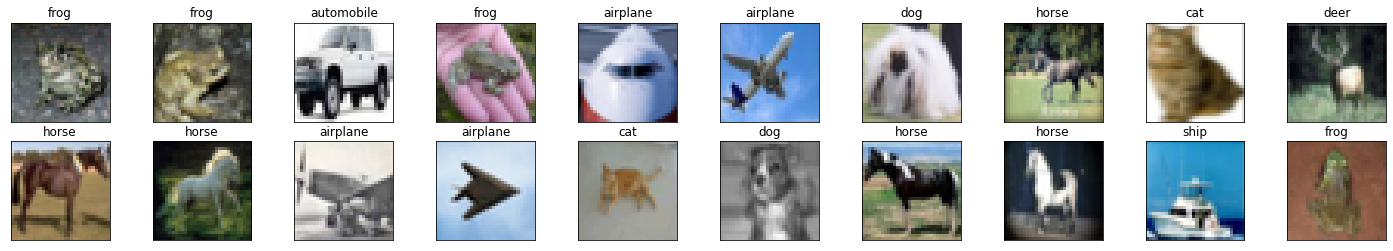

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

To view feature map (red, Green and Blue channels) of the 20th image in the CIFAR1-10 train set

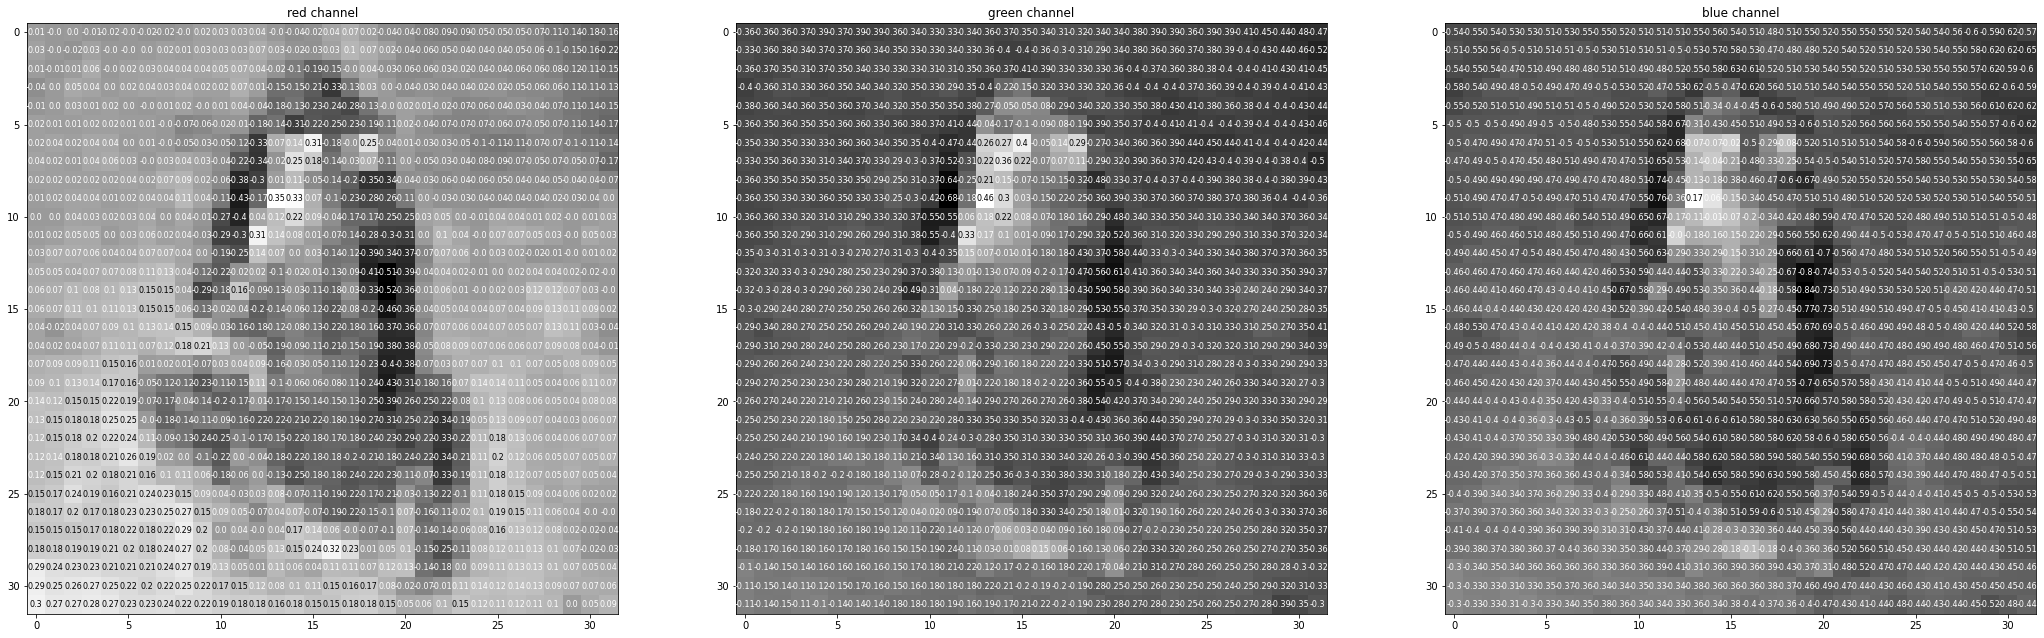

In [ ]:
rgb_img = np.squeeze(images[19])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x), horizontalalignment='center', verticalalignment='center', size=8,color='white' if img[x][y]<thresh else 'black')

Creating a CNN class. The class for our logistic regression model inherits from the nn.Module class from PyTorch library and has a construcotr to initialize itself.<br>
Additionally, the CNN class has **forward** function  that takes an image as an input and makes a prediction on which label it thinks is the right one. After image input through all the convolutional, max pool layers (**nn.Conv2d() and nn.MaxPool2d()**) and  using the relu activation functionto convert the image input from the 3-D input it received into a 1-D vector which the linear layers can work with. Lastly, the last layer uses softmax function that has Cross entropy loss to get a probability distribution for the predictions which image it is.<br>
After declaration, Instantiate the CNN class as **net**.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_layer = nn.Sequential(
             # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """Perform forward."""    
        # conv layers
        x = self.conv_layer(x)      
        # flatten
        x = x.view(x.size(0), -1)    
        # fc layer
        x = self.fc_layer(x)
        return x
# create a complete CNN
net = Net()
print(net)

Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

**Define a loss function and optimizer:** This is done using a classification Cross-Entropy loss, and Stochastic Gradient Descent(SGD) with learning rate of 0.0001 and momentum of 0.1.


In [ ]:
import torch.optim as optim
# specify loss function
criterion = nn.CrossEntropyLoss()
learning_rate=.001
momentum=0.9
# specify optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

**Training** of the model using learning rate of 0.0001 and momentum of 0.9 and number of epochs is 5. Keep track of loss rate for each epoch and finally set minimum epoch with less loss rate
**Save trained model** for future use in predictions, and display the both training and testing loss in each epoch session. Only safe the training model is validation loss has decreased

In [ ]:
n_epochs = 10 # number of epochs to train the model
train_losslist = [] #List to store loss to visualize
valid_loss_min = 5.0 # track change in valid loss
for epoch in range(1, n_epochs+1):
    train_loss = 0.0 # keep track of training loss
    valid_loss=0.0 # keep track of validation loss
    ###################
    # train the model #
    ###################
    net.train()
    for data, target in train_loader:
        optimizer.zero_grad() # clear the gradients of all optimized variables
        output = net(data) # forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output, target) # calculate the batch loss
        loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # perform a single optimization step (parameter update)
        train_loss += loss.item()*data.size(0) # update training loss
    ######################    
    # validate the model #
    ######################
    net.eval()
    for data, target in valid_loader:
        output = net(data)# forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(output, target) # calculate the batch loss
        valid_loss += loss.item()*data.size(0) # update average validation loss 
    
    # calculate average training and validation losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
        
    # print training/validation statistics 
    print('Epoch: {}\nTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation decreased from {:.6f})'.
          format(epoch, train_loss, valid_loss,valid_loss_min))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(net.state_dict(), 'cnn_model_cifar10.pt')
        print("Model has been saved")
        valid_loss_min = valid_loss

Epoch: 1
Training Loss: 1.212923 	Validation Loss: 0.242140 	Validation decreased from 5.000000)
Model has been saved
Epoch: 2
Training Loss: 0.765054 	Validation Loss: 0.170714 	Validation decreased from 0.242140)
Model has been saved
Epoch: 3
Training Loss: 0.595766 	Validation Loss: 0.149031 	Validation decreased from 0.170714)
Model has been saved
Epoch: 4
Training Loss: 0.494587 	Validation Loss: 0.134936 	Validation decreased from 0.149031)
Model has been saved
Epoch: 5
Training Loss: 0.417047 	Validation Loss: 0.122386 	Validation decreased from 0.134936)
Model has been saved
Epoch: 6
Training Loss: 0.349349 	Validation Loss: 0.116775 	Validation decreased from 0.122386)
Model has been saved
Epoch: 7
Training Loss: 0.291810 	Validation Loss: 0.111514 	Validation decreased from 0.116775)
Model has been saved
Epoch: 8
Training Loss: 0.240118 	Validation Loss: 0.131600 	Validation decreased from 0.111514)
Epoch: 9
Training Loss: 0.195389 	Validation Loss: 0.125049 	Validation decre

PLOTTING**PLOTTING** loss rate in training set for each epoch run

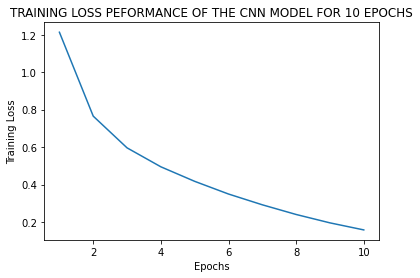

In [ ]:
torch.save(net.state_dict(), 'cnn_model_cifar10.pt')
plt.plot(range(1,n_epochs+1), train_losslist)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("TRAINING LOSS PEFORMANCE OF THE CNN MODEL FOR 10 EPOCHS")
plt.show()

Create a nee CNN object, **net**, and load saved trained model for further classification

In [ ]:
net = Net()
PATH='cnn_model_cifar10.pt'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Get the classification accuracy performance for each the 10 classes and the overall performance of the model. 

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print('\nThe overal accuracy is %2d %%' % (100. * np.sum(class_correct) / np.sum(class_total)))
for i in range(10):
    print('\nAccuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))




The overal accuracy is 81 %

Accuracy of airplane : 87 %

Accuracy of automobile : 88 %

Accuracy of  bird : 67 %

Accuracy of   cat : 67 %

Accuracy of  deer : 74 %

Accuracy of   dog : 73 %

Accuracy of  frog : 83 %

Accuracy of horse : 87 %

Accuracy of  ship : 94 %

Accuracy of truck : 89 %


Carrying out predictions from the model using test data set. We create predict function to use the model in prediction and check_sample function to display the image being predicted, the predicted and desired class.

In [ ]:
def predict(input):
    out = net(input.reshape(1, 3, 32, 32))
    _, pred = torch.max(out, dim=1)
    return classes[pred]

def check_sample(img_label_pair):
    imshow(img_label_pair[0])
    print("Predicted: " + predict(img_label_pair[0]))
    print("Desired output: " + classes[img_label_pair[1]])

Use the code below to test the model classification performance of 10000 cifar10 test dataset using testset[0..9999]

Predicted: horse
Desired output: horse


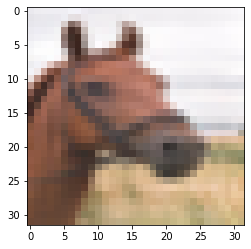

In [ ]:
check_sample(test_data[99])